In [40]:
import scipy.stats
%reset

In [74]:
# 加载所需的库
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.stats import chi2
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [42]:
m = 100
l = pd.Series(np.repeat(1,m))
Delta = 1.7
d = 5
Rho = 0.5
n = 300
np.random.seed(1)

## crude simulation

In [94]:
P_crude = list()

for j in range(100):
    L_crude = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        #Chi_2 = np.random.chisquare(df=d,size=m)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) / np.power(Chi_2/d,0.5)
        L_crude.append(np.sum(l*(x>Delta)))

    L_crude = pd.Series(L_crude)
    p = sum(L_crude>10)/len(L_crude)
    P_crude.append(p)

P_crude = pd.Series(P_crude)

(array([ 3.,  9., 15., 24., 21., 20.,  6.,  0.,  0.,  2.]),
 array([0.18333333, 0.19733333, 0.21133333, 0.22533333, 0.23933333,
        0.25333333, 0.26733333, 0.28133333, 0.29533333, 0.30933333,
        0.32333333]),
 <BarContainer object of 10 artists>)

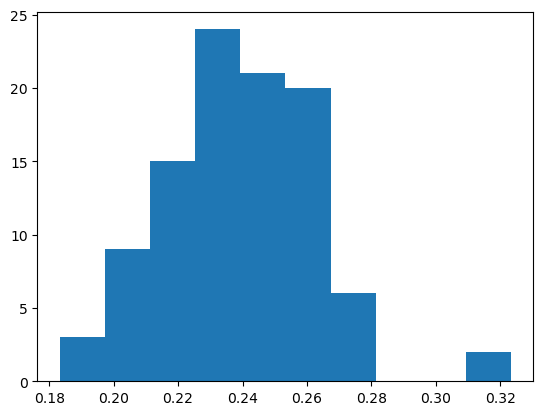

In [95]:
plt.hist(P_crude)

In [96]:
np.mean(P_crude)

0.23826666666666665

In [97]:
np.var(P_crude)


0.0005396622222222222

## Antithetic Variates

In [47]:
np.random.seed(1)
P_AV = list()

for j in range(100):
    p_AV = list()
    for i in range(n):
        #生成仿真
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) \
            / np.power(Chi_2/d,0.5)
        L=np.sum(l*(x>Delta))
        if L > 10:
            p = 1
        else:
            p=0

        #生成Antithetic
        Chi_2_anti = chi2.ppf(q=(1-u), df=d)
        x_anti = (Rho*(-z_0) + np.power((1-np.power(Rho,2)),0.5)*(-z)) \
                 / np.power(Chi_2_anti/d,0.5)
        L_anty = np.sum(l*(x_anti>Delta))
        if L_anty > 10:
            p_anty = 1
        else:
            p_anty=0

        #记录
        p_AV.append((p+p_anty)/2)

    p = np.mean(p_AV)
    P_AV.append(p)

P_AV = pd.Series(P_AV)

(array([ 4.,  8.,  7., 20., 14., 18., 14.,  9.,  4.,  2.]),
 array([0.20833333, 0.21466667, 0.221     , 0.22733333, 0.23366667,
        0.24      , 0.24633333, 0.25266667, 0.259     , 0.26533333,
        0.27166667]),
 <BarContainer object of 10 artists>)

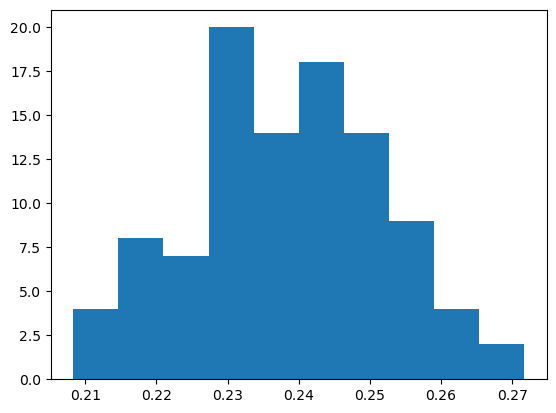

In [48]:
plt.hist(P_AV)

In [49]:
np.mean(P_AV)

0.2382

In [50]:
np.var(P_AV)


0.00017603777777777777

In [83]:
np.var(P_AV)/np.var(P_crude)


0.2656398803535738

## Control variates

In [84]:
np.random.seed(1)
P_CV = list()

for j in range(100):
    L_CV = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)
        z = pd.Series(np.random.normal(loc=0,scale=1,size=m))
        x = (Rho*z_0 + np.power((1-np.power(Rho,2)),0.5)*z) / np.power(Chi_2/d,0.5)
        L = np.sum(l*(x>Delta))
        if L > 10:
            p = 1
        else:
            p=0

        L_CV.append([p]+[z_0]+[Chi_2-d]+list(z))

        #L_CV.insert(L_CV.shape[1],i,[L]+[z_0]+list(Chi_2-d)+list(z))

    L_CV = pd.DataFrame(L_CV)

    y = L_CV.iloc[:, 0] # 因变量
    x = L_CV.iloc[:, 1:] # 自变量

    model = LinearRegression() # 构建线性模型
    model.fit(x, y) # 自变量在前，因变量在后
    predicts = model.predict(x)
    intercept = model.intercept_
    r = y - predicts + intercept

    p = np.mean(r)
    P_CV.append(p)

P_CV = pd.Series(P_CV)


(array([ 4.,  8., 15., 23., 15., 14.,  6.,  6.,  5.,  4.]),
 array([0.18840696, 0.19860719, 0.20880741, 0.21900763, 0.22920786,
        0.23940808, 0.2496083 , 0.25980853, 0.27000875, 0.28020897,
        0.2904092 ]),
 <BarContainer object of 10 artists>)

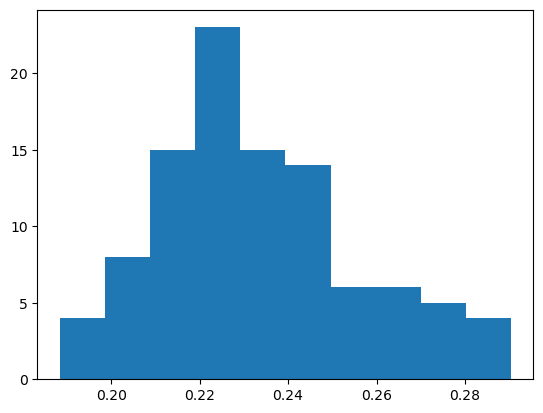

In [85]:
plt.hist(P_CV)

In [86]:
np.mean(P_CV)


0.23327976262877523

In [87]:
np.var(P_CV)


0.0005027419197397793

In [88]:
np.var(P_CV)/np.var(P_crude)

0.7586343402777237

## CONDITIONAL EXPECTATIONS

In [99]:
P_CE = list()
cutoff = norm.ppf(1-10/m)

for j in range(100):
    p_CE = list()

    for i in range(n):
        z_0 = np.random.normal(loc=0,scale=1)
        u = np.random.uniform()
        Chi_2 = chi2.ppf(q=u, df=d)

        y = (Delta * np.power(Chi_2/d,0.5) - Rho*z_0 ) / np.power((1-np.power(Rho,2)),0.5)
        if y < cutoff:
            p = 1
        else:
            p = 0

        p_CE.append(p)

    p = np.mean(p_CE)
    P_CE.append(p)

P_CE = pd.Series(P_crude)

(array([ 3.,  9., 15., 24., 21., 20.,  6.,  0.,  0.,  2.]),
 array([0.18333333, 0.19733333, 0.21133333, 0.22533333, 0.23933333,
        0.25333333, 0.26733333, 0.28133333, 0.29533333, 0.30933333,
        0.32333333]),
 <BarContainer object of 10 artists>)

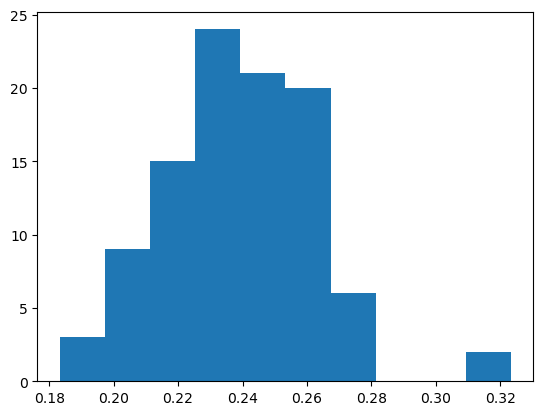

In [100]:
plt.hist(P_CE)

In [101]:
np.mean(P_CE)


0.23826666666666665

In [102]:
np.var(P_CE)


0.0005396622222222222

In [103]:
np.var(P_CE)/np.var(P_crude)


1.0